In [2]:
import math
import os
import shutil
from pathlib import Path
from typing import Callable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import py7zr
import rasterio
import requests
from numpy.typing import NDArray

# I didn't include GDAL in the poetry/poetry.lock because it's a nightmare to get the
# dependencies right and I don't want to block anybody from installing the other depdencies
# In my case I have GDAL 3.3.2
from osgeo import gdal
from rasterio.merge import merge
from tqdm import tqdm

We can derive the slope (%) from the Digital Elevation Model (DEM) provided by the [IGN](https://geoservices.ign.fr/).

There are 3 available DEM datasets with different tile sizes:

- 25m x 25m (625m²) tiles: [BD ALTI](https://geoservices.ign.fr/bdalti)
- 1m x 1m (1m²) or 5m x 5m (25m²) tiles: [RGE ALTI](https://geoservices.ign.fr/rgealti)

For our use case, we will use the BD ALTI dataset. It will provide sufficient accuracy and be easier to work with, as it requires less storage and memory.


In [4]:
BDALTI_DIR = Path("../data/ign/bdalti25")
BDALTI_DIR.mkdir(exist_ok=True, parents=True)

We can check out the assembly map for BD ALTI.
An assembly map is a spatial representation that shows how the tiles of a dataset are organized and indexed, allowing you to easily identify which tiles cover specific areas.

You can download the assembly map here: https://geoservices.ign.fr/sites/default/files/2023-10/BDALTIV2_2-0_TA-25M_SHP_WGS84G_FXX_2023-10-19.zip


In [ ]:
def load_dem_tiles() -> gpd.GeoDataFrame:
    # Download the DEM assembly map from the link and extract the shapefile folder
    tiles = gpd.read_file(BDALTI_DIR / "BDALTIV2_2-0_TA-25M_SHP_WGS84G_FXX_2023-10-19")
    tiles = tiles.drop_duplicates("NOM_DALLE")
    tiles = tiles[tiles["SRC"] == "LAMB93"]
    tiles = tiles[["NOM_DALLE", "geometry"]].rename(columns={"NOM_DALLE": "tile_name"})
    return tiles


tiles = load_dem_tiles()
tiles

,tile_name,geometry
0,BDALTIV2_25M_FXX_0825_6625_MNT_LAMB93_IGN69,"POLYGON ((4.62971 46.48838, 4.63647 46.71344, ..."
1,BDALTIV2_25M_FXX_0850_6525_MNT_LAMB93_IGN69,"POLYGON ((4.92378 45.58306, 4.93162 45.80812, ..."
2,BDALTIV2_25M_FXX_0825_6600_MNT_LAMB93_IGN69,"POLYGON ((4.62301 46.26332, 4.62971 46.48838, ..."
3,BDALTIV2_25M_FXX_0850_6550_MNT_LAMB93_IGN69,"POLYGON ((4.93162 45.80812, 4.93953 46.03317, ..."
4,BDALTIV2_25M_FXX_0875_6550_MNT_LAMB93_IGN69,"POLYGON ((5.25339 45.80215, 5.26262 46.02718, ..."
...,...,...
1843,BDALTIV2_25M_FXX_1200_6175_MNT_LAMB93_IGN78C,"POLYGON ((9.05689 42.27744, 9.08016 42.50149, ..."
1844,BDALTIV2_25M_FXX_1200_6225_MNT_LAMB93_IGN78C,"POLYGON ((9.10361 42.72557, 9.12725 42.9497, 9..."
1846,BDALTIV2_25M_FXX_1200_6250_MNT_LAMB93_IGN78C,"POLYGON ((9.12725 42.9497, 9.15107 43.17387, 9..."
1848,BDALTIV2_25M_FXX_1200_6200_MNT_LAMB93_IGN78C,"POLYGON ((9.08016 42.50149, 9.10361 42.72557, ..."


In [ ]:
# Save the preprocessed assembly map to disk
(BDALTI_DIR / "assembly_map").mkdir(exist_ok=True, parents=True)
tiles.to_file(BDALTI_DIR / "assembly_map/assembly_map.shp")
shutil.make_archive(BDALTI_DIR / "assembly_map", "zip", BDALTI_DIR, "assembly_map")
shutil.rmtree(BDALTI_DIR / "assembly_map")

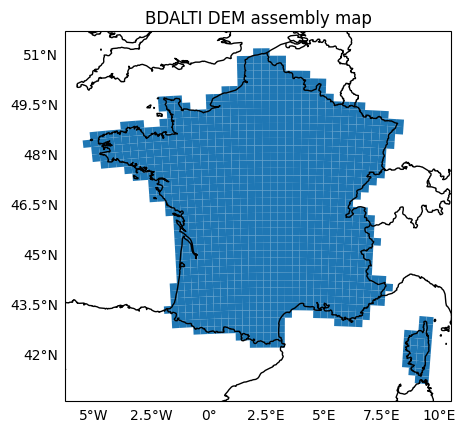

In [84]:
def plot_dem_tiles(tiles: gpd.GeoDataFrame) -> None:
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and countries borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", edgecolor="black")

    # Add latitude and longitude labels on x & y axis
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False

    tiles.plot(ax=ax)
    ax.set_title("BDALTI DEM assembly map")
    plt.show()


plot_dem_tiles(tiles)

The tiles can be downloaded from the [BD ALTI](https://geoservices.ign.fr/bdalti) page.
We download the tiles for each department individually and save them to the `archives/` folder.


In [7]:
def download_file(url: str, filepath: Path) -> None:
    if not filepath.exists():
        response = requests.get(url, stream=True)
        with open(filepath, "wb") as file:
            for chunk in response.iter_content(chunk_size=8092):
                file.write(chunk)


def download_ign_tiles() -> None:
    urls_to_download = [
        "https://data.geopf.fr/telechargement/download/BDALTI/BDALTIV2_2-0_25M_ASC_LAMB93-"
        + filename
        for filename in [
            "IGN69_D001_2023-08-08/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D001_2023-08-08.7z",
            "IGN69_D002_2020-09-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D002_2020-09-04.7z",
            "IGN69_D003_2023-08-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D003_2023-08-10.7z",
            "IGN69_D004_2023-08-08/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D004_2023-08-08.7z",
            "IGN69_D005_2021-08-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D005_2021-08-04.7z",
            "IGN69_D006_2023-08-08/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D006_2023-08-08.7z",
            "IGN69_D007_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D007_2022-12-16.7z",
            "IGN69_D008_2019-10-14/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D008_2019-10-14.7z",
            "IGN69_D009_2023-10-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D009_2023-10-04.7z",
            "IGN69_D010_2021-11-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D010_2021-11-04.7z",
            "IGN69_D011_2023-10-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D011_2023-10-04.7z",
            "IGN69_D012_2022-09-29/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D012_2022-09-29.7z",
            "IGN69_D013_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D013_2022-12-16.7z",
            "IGN69_D014_2022-12-21/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D014_2022-12-21.7z",
            "IGN69_D015_2022-09-29/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D015_2022-09-29.7z",
            "IGN69_D016_2023-07-28/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D016_2023-07-28.7z",
            "IGN69_D017_2023-07-28/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D017_2023-07-28.7z",
            "IGN69_D018_2023-01-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D018_2023-01-03.7z",
            "IGN69_D019_2019-12-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D019_2019-12-10.7z",
            "IGN78C_D02A_2020-04-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN78C_D02A_2020-04-16.7z",
            "IGN78C_D02B_2020-04-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN78C_D02B_2020-04-16.7z",
            "IGN69_D021_2023-01-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D021_2023-01-03.7z",
            "IGN69_D022_2022-10-14/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D022_2022-10-14.7z",
            "IGN69_D023_2019-11-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D023_2019-11-20.7z",
            "IGN69_D024_2019-10-17/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D024_2019-10-17.7z",
            "IGN69_D025_2021-01-13/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D025_2021-01-13.7z",
            "IGN69_D026_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D026_2022-12-16.7z",
            "IGN69_D027_2022-12-21/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D027_2022-12-21.7z",
            "IGN69_D028_2020-01-22/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D028_2020-01-22.7z",
            "IGN69_D029_2022-10-14/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D029_2022-10-14.7z",
            "IGN69_D030_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D030_2022-12-16.7z",
            "IGN69_D031_2021-05-12/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D031_2021-05-12.7z",
            "IGN69_D032_2021-02-11/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D032_2021-02-11.7z",
            "IGN69_D033_2021-05-11/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D033_2021-05-11.7z",
            "IGN69_D034_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D034_2022-12-16.7z",
            "IGN69_D035_2022-12-15/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D035_2022-12-15.7z",
            "IGN69_D036_2022-09-28/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D036_2022-09-28.7z",
            "IGN69_D037_2023-07-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D037_2023-07-20.7z",
            "IGN69_D038_2020-11-13/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D038_2020-11-13.7z",
            "IGN69_D039_2023-08-08/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D039_2023-08-08.7z",
            "IGN69_D040_2021-04-19/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D040_2021-04-19.7z",
            "IGN69_D041_2020-01-22/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D041_2020-01-22.7z",
            "IGN69_D042_2023-08-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D042_2023-08-10.7z",
            "IGN69_D043_2022-10-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D043_2022-10-03.7z",
            "IGN69_D044_2022-12-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D044_2022-12-20.7z",
            "IGN69_D045_2023-01-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D045_2023-01-03.7z",
            "IGN69_D046_2019-12-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D046_2019-12-10.7z",
            "IGN69_D047_2019-11-21/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D047_2019-11-21.7z",
            "IGN69_D048_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D048_2022-12-16.7z",
            "IGN69_D049_2023-07-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D049_2023-07-20.7z",
            "IGN69_D050_2022-12-21/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D050_2022-12-21.7z",
            "IGN69_D051_2020-09-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D051_2020-09-04.7z",
            "IGN69_D052_2021-01-13/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D052_2021-01-13.7z",
            "IGN69_D053_2023-01-12/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D053_2023-01-12.7z",
            "IGN69_D054_2021-11-02/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D054_2021-11-02.7z",
            "IGN69_D055_2019-10-17/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D055_2019-10-17.7z",
            "IGN69_D056_2022-12-15/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D056_2022-12-15.7z",
            "IGN69_D057_2021-11-02/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D057_2021-11-02.7z",
            "IGN69_D058_2023-08-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D058_2023-08-10.7z",
            "IGN69_D059_2021-09-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D059_2021-09-20.7z",
            "IGN69_D060_2020-09-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D060_2020-09-04.7z",
            "IGN69_D061_2023-01-12/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D061_2023-01-12.7z",
            "IGN69_D062_2021-09-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D062_2021-09-20.7z",
            "IGN69_D063_2021-01-22/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D063_2021-01-22.7z",
            "IGN69_D064_2021-04-19/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D064_2021-04-19.7z",
            "IGN69_D065_2020-02-11/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D065_2020-02-11.7z",
            "IGN69_D066_2023-10-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D066_2023-10-04.7z",
            "IGN69_D067_2021-11-02/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D067_2021-11-02.7z",
            "IGN69_D068_2021-11-02/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D068_2021-11-02.7z",
            "IGN69_D069_2023-08-10/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D069_2023-08-10.7z",
            "IGN69_D070_2021-01-13/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D070_2021-01-13.7z",
            "IGN69_D071_2023-01-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D071_2023-01-03.7z",
            "IGN69_D072_2023-01-12/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D072_2023-01-12.7z",
            "IGN69_D073_2020-10-15/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D073_2020-10-15.7z",
            "IGN69_D074_2020-10-15/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D074_2020-10-15.7z",
            "IGN69_D075_2020-07-30/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D075_2020-07-30.7z",
            "IGN69_D076_2020-10-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D076_2020-10-20.7z",
            "IGN69_D077_2021-03-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D077_2021-03-03.7z",
            "IGN69_D078_2020-07-30/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D078_2020-07-30.7z",
            "IGN69_D079_2023-07-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D079_2023-07-20.7z",
            "IGN69_D080_2020-09-04/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D080_2020-09-04.7z",
            "IGN69_D081_2022-07-29/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D081_2022-07-29.7z",
            "IGN69_D082_2021-02-11/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D082_2021-02-11.7z",
            "IGN69_D083_2022-12-05/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D083_2022-12-05.7z",
            "IGN69_D084_2022-12-16/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D084_2022-12-16.7z",
            "IGN69_D085_2023-08-11/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D085_2023-08-11.7z",
            "IGN69_D086_2023-07-20/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D086_2023-07-20.7z",
            "IGN69_D087_2021-10-26/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D087_2021-10-26.7z",
            "IGN69_D088_2021-11-02/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D088_2021-11-02.7z",
            "IGN69_D089_2023-01-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D089_2023-01-03.7z",
            "IGN69_D090_2021-01-13/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D090_2021-01-13.7z",
            "IGN69_D091_2021-03-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D091_2021-03-03.7z",
            "IGN69_D092_2021-03-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D092_2021-03-03.7z",
            "IGN69_D093_2020-07-30/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D093_2020-07-30.7z",
            "IGN69_D094_2021-03-03/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D094_2021-03-03.7z",
            "IGN69_D095_2020-07-30/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D095_2020-07-30.7z",
        ]
    ]

    archives_dir = BDALTI_DIR / "archives"
    archives_dir.mkdir(exist_ok=True, parents=True)
    for url in tqdm(
        urls_to_download, desc="Downloading the tiles of all the French departments"
    ):
        filename = url.split("/")[-1]
        filepath = archives_dir / filename
        if not filepath.exists():
            download_file(url, filepath)


download_ign_tiles()

There are a lot of files in the department archives, but we are only interested by the DEM tiles.
We extract them to a new `elevation/` folder.


In [86]:
def uncompress_ign_tiles() -> None:
    compressed_dir = BDALTI_DIR / "archives"
    uncompressed_dir = BDALTI_DIR / "elevation"

    for archive_filename in tqdm(
        sorted(os.listdir(compressed_dir)), desc="Uncompressing the IGN tiles .7z files"
    ):
        # Extract the tiles files
        with py7zr.SevenZipFile(compressed_dir / archive_filename) as archive:
            tile_filepaths = [f for f in archive.getnames() if f.endswith(".asc")]
            archive.extract(targets=tile_filepaths, path=uncompressed_dir)

        # Move the tiles from their extract folder to the uncompressed folder
        for tile_filpath in tile_filepaths:
            # Don't move the tile if it already exists
            # It can happen since departments share tiles at their borders
            if not (uncompressed_dir / tile_filpath.split("/")[-1]).exists():
                shutil.move(uncompressed_dir / tile_filpath, uncompressed_dir)

        # Delete the empty folder
        shutil.rmtree(uncompressed_dir / archive_filename.replace(".7z", ""))


uncompress_ign_tiles()

Uncompressing the IGN tiles .7z files:   0%|          | 0/96 [00:00<?, ?it/s]

Uncompressing the IGN tiles .7z files: 100%|██████████| 96/96 [03:21<00:00,  2.10s/it]


We perform a sanity check to ensure that the number of uncompressed tiles in our folder matches the number of tiles listed in the assembly map.


In [105]:
assert len(os.listdir(BDALTI_DIR / "elevation")) == len(tiles) == 1017

The tiles are available as .asc ASCII files, which are not very optimized. Therefore, we convert them to TIFF files for better performance and storage efficiency.


In [6]:
def convert_elevation_tiles_from_asc_to_tiff() -> None:
    for filename in tqdm(os.listdir(BDALTI_DIR / "elevation")):
        input_filepath = str(BDALTI_DIR / "elevation" / filename)
        output_filepath = str(BDALTI_DIR / "elevation" / filename.replace(".asc", ".tif"))

        # Translate the .asc file to a new .tif file
        gdal.Translate(output_filepath, gdal.Open(input_filepath))

        # Remove the orignal .asc file
        os.remove(input_filepath)


convert_elevation_tiles_from_asc_to_tiff()

  0%|          | 0/1017 [00:00<?, ?it/s]

100%|██████████| 1017/1017 [02:55<00:00,  5.81it/s]


As an additional sanity check, we visualize one of the elevation tiles. We plot the tile around the "Dune of Pilat" because we know its expected height and slope. This will help us verify that the numbers we obtain are accurate and make sense.


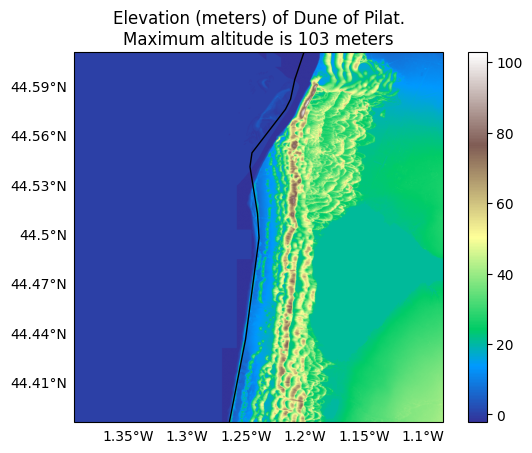

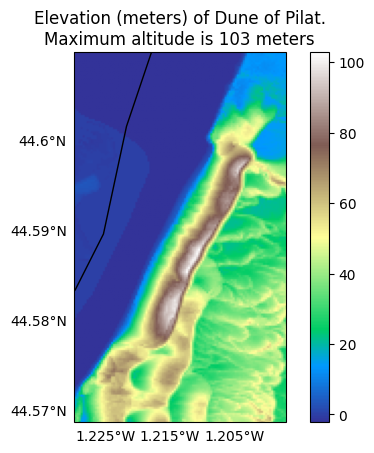

In [ ]:
def plot_raster_with_dune_of_pilat_zoom(
    data_folder: str,
    get_title: Callable[[NDArray[np.number]], str],
    cmap: str,
    show_colorbar: bool,
    zoom_in_dune_of_pilat: bool,
) -> None:
    # Load elevation raster
    with rasterio.open(
        BDALTI_DIR / f"{data_folder}/BDALTIV2_25M_FXX_0350_6400_MNT_LAMB93_IGN69.tif"
    ) as src:
        data = src.read(1)
        bounds = src.bounds

    fig, ax = plt.subplots(
        # We specify LAMB93 (a.k.a., EPSG:2154) projection
        subplot_kw={"projection": ccrs.Projection("EPSG:2154")},
    )

    # Add coastlines and countries borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", edgecolor="black")

    # # Add latitude and longitude labels on x & y axis
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False

    im = ax.imshow(
        data, cmap=cmap, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top)
    )
    if show_colorbar:
        fig.colorbar(im, ax=ax)

    ax.set_title(get_title(data))

    # Set the extent for the Dune Of Pilat region
    if zoom_in_dune_of_pilat:
        ax.set_extent([-1.23, -1.2, 44.57, 44.61], crs=ccrs.PlateCarree())

    plt.show()


def plot_raster(
    data_folder: str,
    get_title: Callable[[NDArray[np.number]], str],
    cmap: str,
    show_colorbar: bool,
) -> None:
    # Plot the full tile
    plot_raster_with_dune_of_pilat_zoom(
        data_folder=data_folder,
        get_title=get_title,
        cmap=cmap,
        show_colorbar=show_colorbar,
        zoom_in_dune_of_pilat=False,
    )
    # Zoom on Dune of Pilat
    plot_raster_with_dune_of_pilat_zoom(
        data_folder=data_folder,
        get_title=get_title,
        cmap=cmap,
        show_colorbar=show_colorbar,
        zoom_in_dune_of_pilat=True,
    )


plot_raster(
    data_folder="elevation",
    get_title=lambda data: f"Elevation (meters) of Dune of Pilat.\nMaximum altitude is {data.max():.0f} meters",
    cmap="terrain",
    show_colorbar=True,
)

We can clearly see the "Dune of Pilat"! And quoting from Google:

> En 2024, la Dune du Pilat culmine à 101 mètres d'altitude, soit plus de deux mètres de moins que la hauteur relevée en 2023, 20 janvier 2025.

101 meters is very close to our max value of 103 meters! Looks Good To me.


Next, we will convert the elevation (in meters) to slope (in %). We will use the Horn algorithm for this conversion. For more information on Horn's algorithm, check out [this page](https://www.aazuspan.dev/blog/terrain-algorithms-from-scratch/).


In [8]:
def compute_slope_from_elevation() -> None:
    (BDALTI_DIR / "slope").mkdir(exist_ok=True, parents=True)
    for filename in tqdm(os.listdir(BDALTI_DIR / "elevation")):
        elevation_input_filepath = str(BDALTI_DIR / "elevation" / filename)
        slope_output_filepath = str(BDALTI_DIR / "slope" / filename)
        gdal.DEMProcessing(
            slope_output_filepath,
            gdal.Open(elevation_input_filepath),
            "slope",
            # By default the edges are None because the Horn algorithm uses a 3x3 kernel that cannot run on the edges
            # With `computeEdges=True`, the input array is extended beyond its boundaries to allow us to run the 3x3
            # kernel and avoid None values
            computeEdges=True,
            slopeFormat="percent",
        )


compute_slope_from_elevation()

  0%|          | 0/1017 [00:00<?, ?it/s]

100%|██████████| 1017/1017 [00:40<00:00, 24.90it/s]


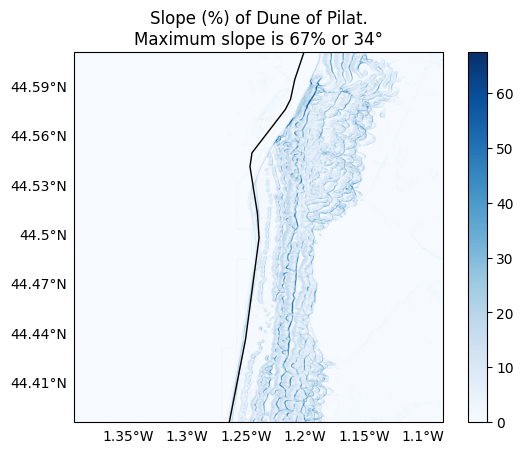

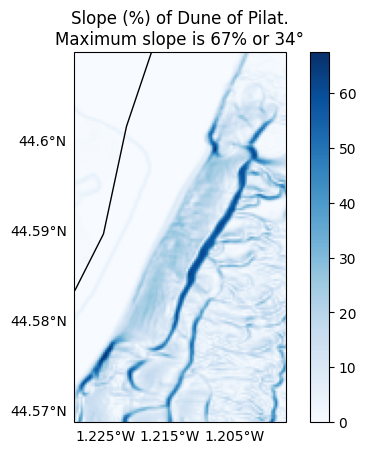

In [81]:
plot_raster(
    data_folder="slope",
    get_title=lambda data: f"Slope (%) of Dune of Pilat.\nMaximum slope is {data.max() / 100:.0%} or {math.degrees(math.atan(data.max() / 100)):.0f}°",
    cmap="Blues",
    show_colorbar=True,
)

A 34° slope sounds about right. From this Wikipedia page: https://fr.wikipedia.org/wiki/Dune_du_Pilat

> En revanche, la face côté forêt, à l'abri du vent (face est), est plus raide, entre 30 et 40°.


For our use case, the exact slope value (whether it's 7% or 42%) isn't very important. We only need to know if the slope is greater than or equal to 30%.

Therefore, we binarize the data. This will simplify processing later and helps save a lot of storage space, as the raster becomes very sparse with only a few pixels having values >= 30%.


In [ ]:
def binarize_slope_gte_30() -> None:
    # Create the output dir if it doesn't exist yet
    (BDALTI_DIR / "slope_gte_30").mkdir(exist_ok=True, parents=True)

    # For each slope raster file
    for filename in tqdm(os.listdir(BDALTI_DIR / "slope")):
        slope_input_filepath = str(BDALTI_DIR / "slope" / filename)
        slope_gte_30_output_filepath = str(BDALTI_DIR / "slope_gte_30" / filename)

        # Open the raster file
        with rasterio.open(slope_input_filepath) as src:
            data = src.read(1)  # Read the first (or only) band
            profile = src.profile  # Copy metadata

        # Apply the threshold
        binary_data = np.where(data >= 30, 1, 0)

        # Update metadata
        profile.update(
            dtype=rasterio.uint8,  # Save as integer
            nodata=0,  # Ignore nodata values and set them to 0 too
            driver="COG",  # Optimized for sparse data
        )

        # Save the result
        with rasterio.open(slope_gte_30_output_filepath, "w", **profile) as dst:
            dst.write(binary_data.astype(rasterio.uint8), 1)


binarize_slope_gte_30()

100%|██████████| 1017/1017 [00:28<00:00, 35.33it/s]


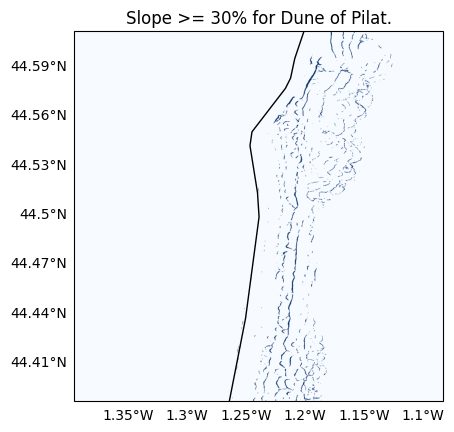

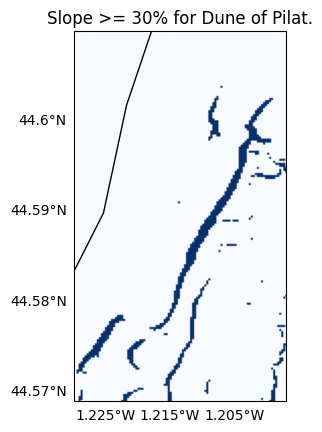

In [ ]:
plot_raster(
    data_folder="slope_gte_30",
    get_title=lambda data: "Slope >= 30% for Dune of Pilat.",
    cmap="Blues",
    show_colorbar=False,
)

At this point, we still have 1,017 individual tiles to manage. Since the data is very sparse, it is manageable to merge them all into a single raster file.

While we won't be able to load the entire resulting grid into memory as a dense array, raster data allows us to load only specific areas of the file. In our case, we can load just the areas or bounding box around the clear cuts.


In [93]:
def merge_raster_tiles() -> None:
    # Open the rasters
    src_files_to_mosaic = [
        rasterio.open(BDALTI_DIR / "slope_gte_30" / filename)
        for filename in os.listdir(BDALTI_DIR / "slope_gte_30")
    ]

    # Merge rasters
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Update metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update(
        {
            "driver": "COG",  # Optimized for sparse data
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform,
        }
    )

    # Write to a new raster file
    with rasterio.open(BDALTI_DIR / "slope_gte_30.tif", "w", **out_meta) as dest:
        dest.write(mosaic)

    # Close the opened rasters
    for src in src_files_to_mosaic:
        src.close()


merge_raster_tiles()

Finally, we can upload the result to S3


In [10]:
!aws s3 cp ../data/ign/bdalti25/slope_gte_30.tif s3://brigade-coupe-rase-s3/analytics/data/ign/bdalti25/slope_gte_30.tif --profile d4g-s13-brigade-coupes-rases

upload: ../data/ign/bdalti25/slope_gte_30.tif to s3://brigade-coupe-rase-s3/analytics/data/ign/bdalti25/slope_gte_30.tif


In [12]:
!aws s3 ls s3://brigade-coupe-rase-s3/ --recursive --profile d4g-s13-brigade-coupes-rases

2025-02-18 21:53:57   32993275 analytics/data/ign/bdalti25/slope_gte_30.tif
